# Evaluate finetuned model

In [3]:
id2label = {
    0: "background",  # No object
    1: "pedestrian",
    2: "car",
}
label2id = {v: k for k, v in id2label.items()}

In [4]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, AutoModelForUniversalSegmentation
from PIL import Image
import requests
import torch

# Load Mask2Former trained on COCO instance segmentation dataset
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/mask2former-swin-large-coco-instance",
    use_fast=True
)
model = AutoModelForUniversalSegmentation.from_pretrained(
    pretrained_model_name_or_path="mask2former_kitti_finetuned_v2/checkpoint-5650",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

image_path = "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/data/KITTI_MOTS/training/image_02/val/0016/000080.png"
image = Image.open(image_path)
inputs = image_processor(image, return_tensors="pt")


print("Predicting...")
with torch.no_grad():
    outputs = model(**inputs)
print("Prediction finished")

# Model predicts class_queries_logits of shape '(batch_size, num_queries)'
# and masks_queries_logits of shape '(batch_size, num_queries, height, width)'
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

print(class_queries_logits)
print(masks_queries_logits)

# Perform post-processing to get instance segmentation map
pred_instance_map = image_processor.post_process_instance_segmentation(
    outputs, threshold=0.15, target_sizes = [(image.height, image.width)]
)[0]



/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/.venv/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


Predicting...
Prediction finished
tensor([[[ 2.3786e-01, -2.8946e+00, -8.5313e-01,  2.7302e+00],
         [-1.2067e+00, -4.1239e+00,  9.5163e-01,  2.9076e+00],
         [-1.4344e+00, -3.9457e+00,  1.5729e+00,  2.6524e+00],
         [-6.5163e-01, -3.5308e+00,  1.3307e-01,  2.9041e+00],
         [ 2.1265e+00, -2.7339e+00, -1.2512e+00,  1.8630e+00],
         [ 2.0037e+00, -3.0891e+00, -1.5124e+00,  1.7213e+00],
         [-1.5530e+00, -3.8542e+00,  9.4692e-01,  3.1842e+00],
         [-9.0055e-01, -3.9473e+00,  1.4762e+00,  2.5715e+00],
         [ 1.2502e+00, -3.4413e+00, -8.7725e-01,  2.3566e+00],
         [-5.2014e-01, -3.6427e+00,  2.7649e-01,  2.7501e+00],
         [-1.0087e+00, -3.6293e+00,  3.9159e-01,  2.8351e+00],
         [ 6.6325e-02, -3.6247e+00,  4.1501e-01,  2.4509e+00],
         [-8.2185e-01, -3.7205e+00,  2.4810e-01,  3.1270e+00],
         [ 6.2239e-01, -3.1148e+00, -7.1761e-01,  2.6325e+00],
         [ 5.7182e-01, -3.3404e+00, -3.9901e-01,  2.8747e+00],
         [ 1.4267e-01

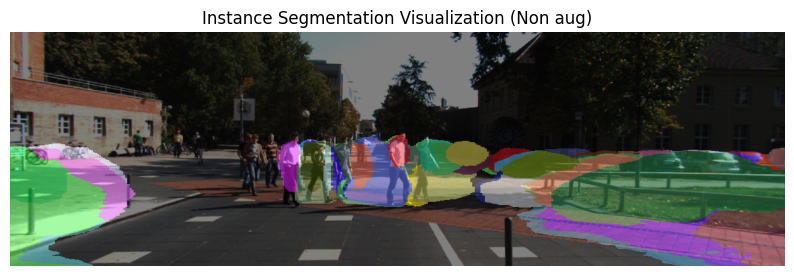

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the predicted instance segmentation map
instance_map = pred_instance_map["segmentation"].numpy()

# Generate unique colors for each instance
num_instances = int(np.max(instance_map) + 1)  # Number of unique instances
colors = np.random.randint(0, 255, size=(num_instances, 3), dtype=np.uint8)

# Create a colorized mask image
color_mask = np.zeros((*instance_map.shape, 3), dtype=np.float32)
for i in range(1, num_instances):  # Skip background (assumed to be 0)
    color_mask[instance_map == i] = colors[i]

# Convert the original image to numpy
image_np = np.array(image)

# Overlay the mask with some transparency
overlay = (0.5 * image_np + 0.5 * color_mask).astype(np.uint8)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis("off")
plt.title("Instance Segmentation Visualization (Non aug)")
plt.show()

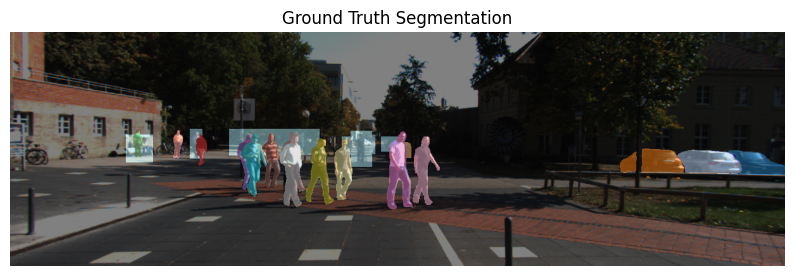

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Paths to the image and its ground truth mask
image_path = "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/data/KITTI_MOTS/training/image_02/val/0016/000080.png"
mask_path = "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/data/KITTI_MOTS/instances/0016/000080.png"

# Load the image and mask
image = Image.open(image_path).convert("RGB")
mask = np.array(Image.open(mask_path))

# Get the unique instance ids; assuming 0 is the background, skip it if present
instance_ids = np.unique(mask)
if instance_ids[0] == 0:
    instance_ids = instance_ids[1:]

# Use a built-in colormap (e.g., 'tab20') to generate distinct colors for each instance
cmap = plt.get_cmap('tab20', len(instance_ids))

# Create an empty RGB image for the colored mask
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)

# Map each instance to a unique color from the colormap
for i, inst in enumerate(instance_ids):
    # Get the color for this instance (ignoring the alpha channel)
    color = cmap(i)[:3]
    # Assign the color to the pixels belonging to this instance
    colored_mask[mask == inst] = color

# Visualize the original image with the colored mask overlay
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.imshow(colored_mask, alpha=0.5)  # Adjust the transparency (alpha) as needed
plt.title("Ground Truth Segmentation")
plt.axis('off')
plt.show()



In [ ]:
import os
import json
import torch
import numpy as np
from PIL import Image
from torchvision.ops import masks_to_boxes
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, AutoModelForUniversalSegmentation
from tqdm import tqdm
from torchvision import transforms


# Load Mask2Former trained on COCO instance segmentation dataset
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-instance")
model = AutoModelForUniversalSegmentation.from_pretrained(
    "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/week2/Mask2Former/mask2former_kitti_finetuned_v2/checkpoint-5650",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model.eval()

# Define paths
BASE_DIR = "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/data/KITTI_MOTS"
image_dir = os.path.join(BASE_DIR, "training/image_02/val")
mask_dir = os.path.join(BASE_DIR, "instances")  # Use preprocessed masks directory
annotation_file = "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/data/val_data_kitti_mots_coco.json"

# Load ground truth annotations
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Define Transform for Images
image_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

COCO_CATEGORY_MAPPING = {
    1: 2,  # KITTI car → COCO car
    2: 0,  # KITTI pedestrian → COCO person
    10: None,  # Ignore class
}

# Define KITTI Dataset
class KITTIDataset(Dataset):
    def __init__(self, annotations, image_dir, mask_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform  # Apply transformations if provided

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.image_dir, ann["image"])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)  # Convert to tensor

        gt_boxes, gt_labels, gt_masks = [], [], []
        objs = ann

        for i in range(len(ann["objects"]["id"])):
            mask_path = os.path.join(self.mask_dir, ann["image"])
            if not os.path.exists(mask_path):
                continue
            mask = np.array(Image.open(mask_path)) // 255  # Convert to binary mask

            if mask.sum() == 0:
                continue  # Ignore empty masks

            kitti_class = ann["objects"]["category"][i]
            coco_class = COCO_CATEGORY_MAPPING.get(kitti_class, None)

            if coco_class is None:
                continue  # Ignore class

            gt_masks.append(mask)
            gt_labels.append(coco_class)

        gt_masks = np.array(gt_masks, dtype=bool)  # Shape: (num_objects, H, W)


        return {
        "image": image,  # Now a tensor
        "gt_labels": torch.tensor(gt_labels, dtype=torch.int64),
        "gt_masks": torch.tensor(gt_masks, dtype=torch.bool),
    }

def custom_collate(batch):
    images = [item["image"] for item in batch]
    gt_labels = [item["gt_labels"] for item in batch]
    gt_masks = [item["gt_masks"] for item in batch]  # Keep masks as a list to prevent stacking issues

    return {
        "images": images,  # List of image tensors
        "gt_labels": gt_labels,  # List of label tensors
        "gt_masks": gt_masks,  # List of mask tensors
    }

print("Processing KITTI Dataset")
# Create dataset and dataloader
dataset = KITTIDataset(annotations, image_dir, mask_dir, transform=image_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=custom_collate)

print("Finished loading KITTI Dataset")

# Perform segmentation predictions and evaluation
# Perform segmentation predictions and evaluation
all_pred_boxes, all_gt_boxes = [], []
for batch in tqdm(dataloader, desc="Processing Batches"):
    images = [item for item in batch["images"]]
    gt_labels = [item for item in batch["gt_labels"]]
    gt_masks = [item for item in batch["gt_masks"]]

    # Convert images back to PIL if necessary
    if isinstance(images[0], torch.Tensor):
        images = [transforms.ToPILImage()(img) for img in images]

    # Preprocess images
    inputs = image_processor(images, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process segmentation results
    pred_instance_maps = image_processor.post_process_instance_segmentation(
        outputs, threshold=0.1, target_sizes=[(img.size[1], img.size[0]) for img in images]  # Ensure correct size order
    )

    for i in range(len(pred_instance_maps)):
        pred_boxes, pred_labels, pred_masks, pred_scores = [], [], [], []
        instance_map = pred_instance_maps[i]

        segmentation_mask = instance_map["segmentation"].cpu().numpy()  # Get segmentation map for the whole image
        segments_info = instance_map["segments_info"]

        # Iterate through segments and create individual object masks
        for j, segment in enumerate(segments_info):
            object_mask = (segmentation_mask == segment["id"]).astype(np.uint8)  # Create binary mask for the object
            pred_masks.append(object_mask)

            # Extract bounding box, label, and score
            pred_labels.append(int(segment["label_id"]))
            pred_scores.append(float(segment["score"]))

        all_gt_boxes.append({
            "labels": gt_labels[i],
            "masks": gt_masks[i],
        })
        all_pred_boxes.append({
            "labels": torch.tensor(pred_labels, dtype=torch.int),
            "scores": torch.Tensor(pred_scores),
            "masks": torch.tensor(np.array(pred_masks, dtype=np.uint8), dtype=torch.bool),
        })

# Compute mean Average Precision (mAP) and IoU
metric = MeanAveragePrecision(iou_type="segm", box_format="xyxy", class_metrics=True)
metric.update(all_pred_boxes, all_gt_boxes)
metrics = metric.compute()

print("Evaluation Metrics:")
print(metrics)

Processing KITTI Dataset
Finished loading KITTI Dataset


Processing Batches:   6%|▋         | 42/661 [02:20<33:28,  3.25s/it]